# Load Dataset from ~/data

>  Import libraries


In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd

> Define source directories

In [7]:
root = "../data"
labels = os.listdir(root)[:2]
datapath = []
for label in labels:
    datapath.append(os.path.join(root, label))
datapath


['../data/Uninfected', '../data/Parasitized']

>Display sample images


In [8]:
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10, 10
from random import randint

(-0.5, 111.5, 135.5, -0.5)

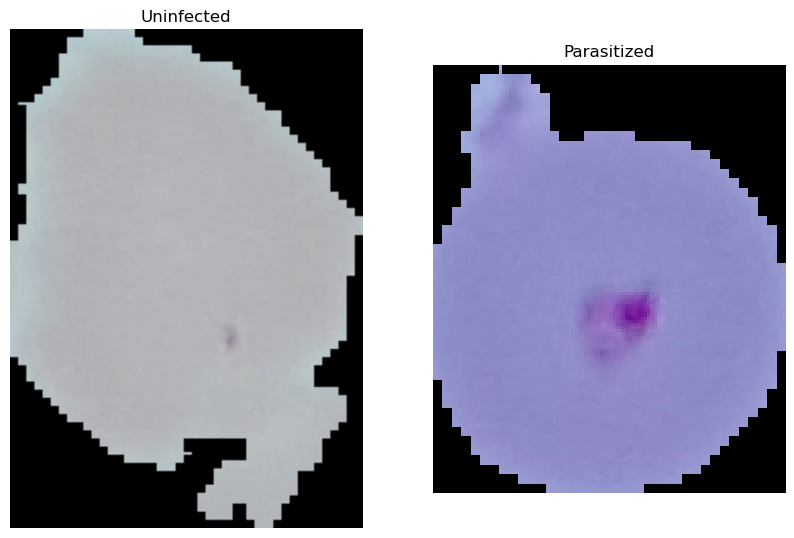

In [9]:
# read two random images
img_uninfected = cv2.imread(
    os.path.join(
        datapath[0], os.listdir(datapath[0])[randint(0, len(os.listdir(datapath[0])))]
    )
)
img_infected = cv2.imread(
    os.path.join(
        datapath[1], os.listdir(datapath[1])[randint(0, len(os.listdir(datapath[1])))]
    )
)
# plot images
fig, ax = plt.subplots(1, 2)
ax[0].set_title(labels[0])
ax[0].imshow(img_uninfected)
ax[0].axis("off")
ax[1].set_title(labels[1])
ax[1].imshow(img_infected)
ax[1].axis("off")

> Resize images

In [19]:
# define empty dataframe to store image data
df = pd.DataFrame(columns=["Image", "label"])
# loop over labels
for label in labels:
    pwd = os.path.join(root, label)
    for _ in os.listdir(pwd):
        # load images then resize them to a fixed size
        img = cv2.imread(os.path.join(pwd, _))
        img = cv2.resize(img, (64, 64))
        # flatten the image into a list of raw pixel intensities then
        # add the image and label to our training data
        df = pd.concat([df, pd.DataFrame({"Image": [img], "label": [label]})])
df.head()


,Image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Uninfected
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Uninfected
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Uninfected
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Uninfected
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Uninfected


In [17]:
pd.concat([df, pd.DataFrame({"Image": [img], "label": [label]})])


,Image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Parasitized
